In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import lightgbm as lgb
import joblib

In [2]:
# Dataset hasil augmentasi
data = pd.read_csv("data/prepData3.csv")

data.isna().sum()

text            0
label           0
clean_text      0
stemmed_text    0
dtype: int64

In [3]:
print("Jumlah data:", len(data))
print("Distribusi label:\n", data['label'].value_counts())

Jumlah data: 23677
Distribusi label:
 Politik                    2969
Geografi                   2969
Pertahanan dan Keamanan    2966
Ideologi                   2964
Ekonomi                    2956
Sosial Budaya              2956
Demografi                  2954
Sumber Daya Alam           2943
Name: label, dtype: int64


In [4]:
data = data.dropna(subset=['stemmed_text'])

In [5]:
print("Jumlah data:", len(data))
print("Distribusi label:\n", data['label'].value_counts())

Jumlah data: 23677
Distribusi label:
 Politik                    2969
Geografi                   2969
Pertahanan dan Keamanan    2966
Ideologi                   2964
Ekonomi                    2956
Sosial Budaya              2956
Demografi                  2954
Sumber Daya Alam           2943
Name: label, dtype: int64


In [41]:
vectorizer = TfidfVectorizer(
    max_features=10000,  # batas fitur
    ngram_range=(1, 2),  # unigram + bigram
    min_df=5             # kata muncul min. 5 dokumen
)

X = vectorizer.fit_transform(data['stemmed_text'])

# Simpan vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Encode label
le = LabelEncoder()
y = le.fit_transform(data['label'])
joblib.dump(le, "label_encoder.pkl")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (18941, 10000) Test size: (4736, 10000)


## XGBOOST

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import numpy as np

# Parameter model XGBoost
xgb_params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "eval_metric": "mlogloss",
    "tree_method": "hist"
}

# Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
macro_f1_scores = []
weighted_f1_scores = []

best_macro_f1 = -1
best_model = None

fold = 1
for train_idx, val_idx in kf.split(X, y):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Buat model baru untuk setiap fold
    model = XGBClassifier(**xgb_params)
    model.fit(X_train_fold, y_train_fold)
    
    # Prediksi di validation fold
    y_pred = model.predict(X_val_fold)
    
    # Hitung metrik
    acc = accuracy_score(y_val_fold, y_pred)
    macro_f1 = f1_score(y_val_fold, y_pred, average="macro")
    weighted_f1 = f1_score(y_val_fold, y_pred, average="weighted")
    
    acc_scores.append(acc)
    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)
    
    print(f"Fold {fold} - Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}, Weighted F1: {weighted_f1:.4f}")
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model = model
    
    fold += 1

# Rata-rata skor
print("\n=== Cross-Validation Summary ===")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average Macro F1: {np.mean(macro_f1_scores):.4f}")
print(f"Average Weighted F1: {np.mean(weighted_f1_scores):.4f}")

# Simpan model terbaik
joblib.dump(best_model, "xgb_model.pkl")
print(f"\nBest model saved with Macro F1: {best_macro_f1:.4f} -> xgb_model.pkl")

Fold 1 - Accuracy: 0.9062, Macro F1: 0.9066, Weighted F1: 0.9066
Fold 2 - Accuracy: 0.9043, Macro F1: 0.9042, Weighted F1: 0.9042
Fold 3 - Accuracy: 0.9073, Macro F1: 0.9073, Weighted F1: 0.9073
Fold 4 - Accuracy: 0.9060, Macro F1: 0.9059, Weighted F1: 0.9059
Fold 5 - Accuracy: 0.9048, Macro F1: 0.9054, Weighted F1: 0.9054

=== Cross-Validation Summary ===
Average Accuracy: 0.9057
Average Macro F1: 0.9059
Average Weighted F1: 0.9059

Best model saved with Macro F1: 0.9073 -> xgb_model.pkl


## LGBM

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import lightgbm as lgb
import numpy as np
import joblib

# Parameter LightGBM
lgb_params = {
    "n_estimators": 300,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
macro_f1_scores = []
weighted_f1_scores = []

best_macro_f1 = -1
best_model = None

fold = 1
for train_idx, val_idx in kf.split(X, y):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train_fold, y_train_fold)
    
    y_pred = model.predict(X_val_fold)
    
    acc = accuracy_score(y_val_fold, y_pred)
    macro_f1 = f1_score(y_val_fold, y_pred, average="macro")
    weighted_f1 = f1_score(y_val_fold, y_pred, average="weighted")
    
    acc_scores.append(acc)
    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)
    
    print(f"Fold {fold} - Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}, Weighted F1: {weighted_f1:.4f}")
    
    # Simpan model terbaik berdasarkan Macro F1
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model = model
    
    fold += 1

print("\n=== Cross-Validation Summary ===")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average Macro F1: {np.mean(macro_f1_scores):.4f}")
print(f"Average Weighted F1: {np.mean(weighted_f1_scores):.4f}")

# Simpan model terbaik
joblib.dump(best_model, "lgb_model.pkl")
print(f"\nBest model saved with Macro F1: {best_macro_f1:.4f} -> lgb_model.pkl")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156986
[LightGBM] [Info] Number of data points in the train set: 18941, number of used features: 5392
[LightGBM] [Info] Start training from score -2.081397
[LightGBM] [Info] Start training from score -2.080551
[LightGBM] [Info] Start training from score -2.076331
[LightGBM] [Info] Start training from score -2.078017
[LightGBM] [Info] Start training from score -2.077174
[LightGBM] [Info] Start training from score -2.076331
[LightGBM] [Info] Start training from score -2.080551
[LightGBM] [Info] Start training from score -2.085213
Fold 1 - Accuracy: 0.9231, Macro F1: 0.9233, Weighted F1: 0.9233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [47]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
import joblib

# Load model terbaik hasil cross-validation
xgb_best_model = joblib.load("xgb_model.pkl")
lgb_best_model = joblib.load("lgb_model.pkl")

# === Evaluasi XGBoost ===
y_pred_xgb = xgb_best_model.predict(X_test)

print("=== XGBoost Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# === Evaluasi LightGBM ===
y_pred_lgb = lgb_best_model.predict(X_test)

print("=== LightGBM Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred_lgb, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test, y_pred_lgb, average='weighted'):.4f}")
print(classification_report(y_test, y_pred_lgb, target_names=le.classes_))


=== XGBoost Evaluation ===
Accuracy: 0.9753
Macro F1: 0.9752
Weighted F1: 0.9752
                         precision    recall  f1-score   support

              Demografi       0.99      0.99      0.99       591
                Ekonomi       0.98      0.99      0.98       591
               Geografi       1.00      1.00      1.00       594
               Ideologi       0.98      0.97      0.98       593
Pertahanan dan Keamanan       0.97      0.99      0.98       593
                Politik       0.95      0.93      0.94       594
          Sosial Budaya       0.95      0.94      0.95       591
       Sumber Daya Alam       0.98      0.98      0.98       589

               accuracy                           0.98      4736
              macro avg       0.98      0.98      0.98      4736
           weighted avg       0.98      0.98      0.98      4736

=== LightGBM Evaluation ===
Accuracy: 0.9827
Macro F1: 0.9827
Weighted F1: 0.9827
                         precision    recall  f1-score


=== XGBoost Final Evaluation ===
MAE : 0.0623
MSE : 0.2333
RMSE: 0.4830


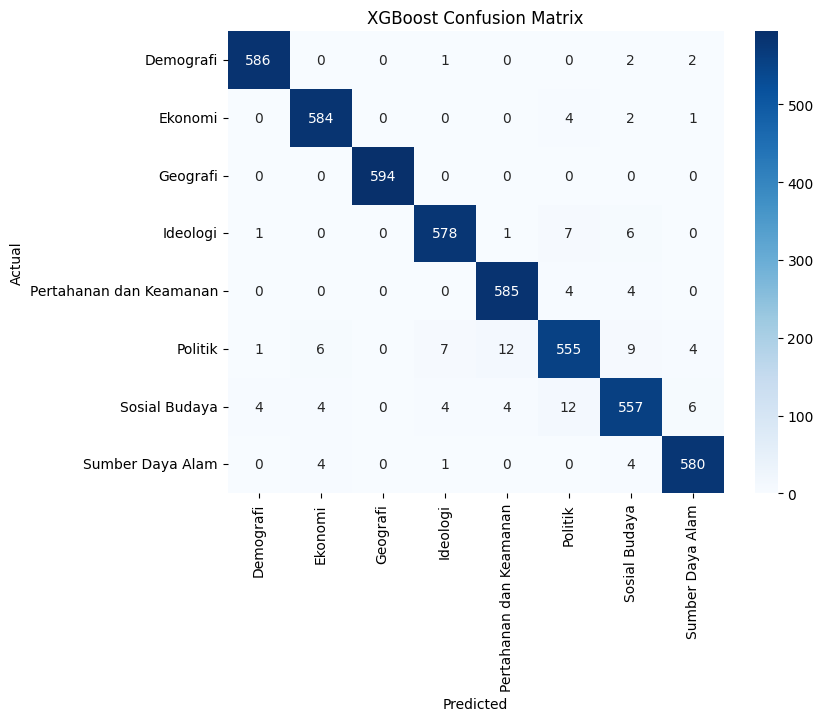

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah prediksi & y_test ke label asli
y_test_labels = le.inverse_transform(y_test)
y_pred_xgb_labels = le.inverse_transform(xgb_best_model.predict(X_test))
y_pred_lgb_labels = le.inverse_transform(lgb_best_model.predict(X_test))

# === XGBOOST ===
mae_xgb = mean_absolute_error(y_test, xgb_best_model.predict(X_test))
mse_xgb = mean_squared_error(y_test, xgb_best_model.predict(X_test))
rmse_xgb = np.sqrt(mse_xgb)

print("\n=== XGBoost Final Evaluation ===")
print(f"MAE : {mae_xgb:.4f}")
print(f"MSE : {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")

cm_xgb = confusion_matrix(y_test_labels, y_pred_xgb_labels, labels=le.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== LightGBM Final Evaluation ===
MAE : 0.0420
MSE : 0.1417
RMSE: 0.3764


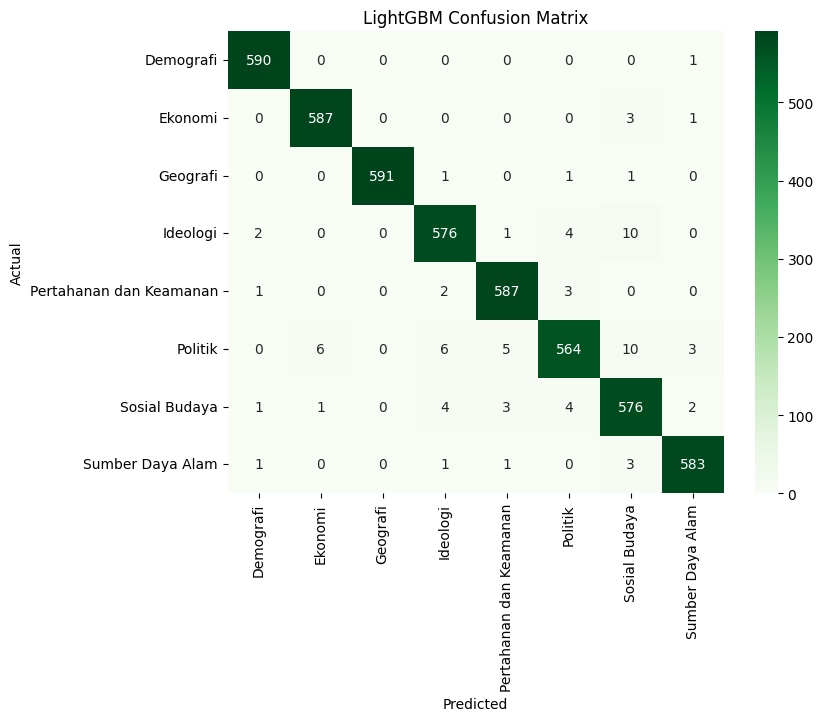

In [56]:
mae_lgb = mean_absolute_error(y_test, lgb_best_model.predict(X_test))
mse_lgb = mean_squared_error(y_test, lgb_best_model.predict(X_test))
rmse_lgb = np.sqrt(mse_lgb)

print("\n=== LightGBM Final Evaluation ===")
print(f"MAE : {mae_lgb:.4f}")
print(f"MSE : {mse_lgb:.4f}")
print(f"RMSE: {rmse_lgb:.4f}")

cm_lgb = confusion_matrix(y_test_labels, y_pred_lgb_labels, labels=le.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()